In [89]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score,train_test_split
from collections import Counter
from utils_ import reduce_mem_usage, feat_imp,make_label_enc,freq_enc
from datetime import datetime, date, time,timedelta
import lightgbm 
import shap
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold

In [90]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [91]:
train = pd.read_csv('../L3/assignment_2_train.csv')
# test = pd.read_csv('../L3/assignment_2_test.csv')


In [92]:
train=reduce_mem_usage(train)

Memory usage of dataframe is 541.08 MB
Memory usage after optimization is: 279.29 MB
Decreased by 48.4%


In [222]:
x=train.drop('isFraud', axis=1)
y=train.isFraud

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.

In [94]:
params_xg = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.09,
    'reg_alpha':0.6,
    'min_child_weight':4,
    "n_estimators": 200,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "seed": 101
}

In [95]:
xgb = xgboost.XGBClassifier(**params_xg)


In [96]:
def freq_enc(x,features):
    
    for feature in features:
        freq_encoder = x[feature].value_counts(normalize=True)
        x[feature] = x[feature].map(freq_encoder)
        x[feature]=x[feature].astype(float)
    return x

In [97]:
def make_stat(x,base_feature, features):
    
    for feature in features:
        name_=base_feature+'_'+feature       
        temp=x[[base_feature,feature]].groupby(feature).agg(['mean','std'])
        temp[name_]=temp[base_feature]['mean']/temp[base_feature]['std']
        x=x.merge(temp[[name_]].droplevel(1,axis=1),on=feature,right_index=True, how='left')
        x[name_]=x[base_feature]/x[name_]
    return x

In [223]:
def prep_data(x):
    
    
    x['TransactionDT_copy']=x.TransactionDT.apply(lambda x:datetime.fromisoformat('2017-12-01')+timedelta(minutes=x/60))
    time_measures=['year','month','weekday','hour','day']

    for measure in time_measures:

        x['TransactionDT_' + measure]=x.TransactionDT_copy.apply(lambda x:getattr(x,measure))

    x['TransactionDT_weekday']=x['TransactionDT_weekday'].apply(lambda x:x())    
    x=x.drop('TransactionDT_copy', axis=1)
    
        
    x['card12']=x.card1+x.card2
    x['card1235']=x.card1+x.card2+x.card3+x.card5
    x['card1235_addr12']=x['card1235']+x.addr1+x.addr2

    x['card12']=x['card12']
    x['card1235']=x['card1235']
    x['card1235_addr12']=x['card1235_addr12']
    
    features=['card1','card2','card3','card4','card5','card6','addr1','addr2']
    x=freq_enc(x,features)
    
    x=make_stat(x,'D15', features)
    
    x['TransactionAmt_fract']=x.TransactionAmt.apply(lambda x:x%1)
    x['TransactionAmt_whole']=x.TransactionAmt.apply(int)
    x['TransactionAmt_log']=x.TransactionAmt.apply(np.log)
    
    n= Counter(x[['P_emaildomain','R_emaildomain']].values.flatten())
    p=np.array(list(n.values())[1:])/sum(list(n.values())[1:])
    values_=list(n.keys())[1:]
    size_=x[(x.P_emaildomain.isnull()) & (x.R_emaildomain.isnull())].shape[0]
    l1=np.random.choice(values_,size=size_,p=p)
    l2=np.random.choice(values_,size=size_,p=p)
    index_=x.loc[(x.P_emaildomain.isnull()) & (x.R_emaildomain.isnull())].index
    x.loc[index_,'R_emaildomain' ]=l1
    x.loc[index_,'P_emaildomain' ]=l2
    
    x.R_emaildomain.fillna(x.P_emaildomain, inplace=True)
    x.P_emaildomain=x.P_emaildomain.fillna(x.R_emaildomain)
    cat_feat=x.select_dtypes(include='object').columns.tolist()
    x=freq_enc(x,cat_feat)
    
    return x
  

In [224]:
x = prep_data(x)

In [225]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8, random_state=101)

In [137]:
xgb.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.64972	validation_1-auc:0.65107
[50]	validation_0-auc:0.87732	validation_1-auc:0.87874
[100]	validation_0-auc:0.90636	validation_1-auc:0.90553
[150]	validation_0-auc:0.91550	validation_1-auc:0.91309
[199]	validation_0-auc:0.91724	validation_1-auc:0.91432


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=4, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=101, reg_alpha=0.6,
              reg_lambda=100, scale_pos_weight=1, seed=101, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

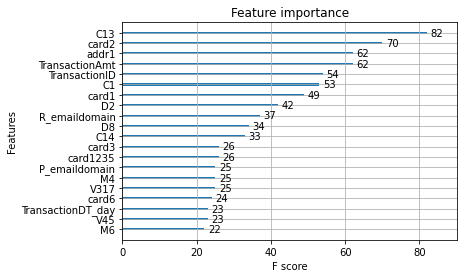

In [138]:
xgboost.plot_importance(xgb,max_num_features=20)

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.

In [139]:
f=feat_imp(x_train.columns, xgb.feature_importances_)
drop_feat=f[f.feature_importance==0].feature.values
f.head(10)

,feature,feature_importance
0,V201,0.084092
1,V244,0.060687
2,V189,0.049915
3,V258,0.047247
4,V243,0.033969
5,C8,0.023051
6,C4,0.018471
7,C7,0.018367
8,V134,0.018122
9,M4,0.015958


In [140]:
xgb = xgboost.XGBClassifier(**params_xg)
xgb.fit(
    X=x_train.drop(drop_feat, axis=1),
    y=y_train,
    eval_set=[(x_train.drop(drop_feat, axis=1), y_train), 
              (x_test.drop(drop_feat, axis=1), y_test)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.64972	validation_1-auc:0.65107
[50]	validation_0-auc:0.87732	validation_1-auc:0.87874
[100]	validation_0-auc:0.90636	validation_1-auc:0.90553
[150]	validation_0-auc:0.91550	validation_1-auc:0.91309
[199]	validation_0-auc:0.91724	validation_1-auc:0.91432


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=4, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=101, reg_alpha=0.6,
              reg_lambda=100, scale_pos_weight=1, seed=101, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [230]:
# без изменений

Задание 3: использовать permutation importance, выполнить задание 1 и 2.

In [143]:
xgb = xgboost.XGBClassifier(**params_xg)
xgb.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.64972	validation_1-auc:0.65107
[50]	validation_0-auc:0.87732	validation_1-auc:0.87874
[100]	validation_0-auc:0.90636	validation_1-auc:0.90553
[150]	validation_0-auc:0.91550	validation_1-auc:0.91309
[199]	validation_0-auc:0.91724	validation_1-auc:0.91432


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=4, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=101, reg_alpha=0.6,
              reg_lambda=100, scale_pos_weight=1, seed=101, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [146]:
importance = permutation_importance(
    xgb, x_test, y_test,n_repeats=2, scoring="roc_auc", n_jobs=3, random_state=27
)

In [179]:
importance_scores = pd.DataFrame({
    "features": x_train.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)
drop_feat=decrease_scores['features'].tolist()

<AxesSubplot:xlabel='importance-mean', ylabel='features'>

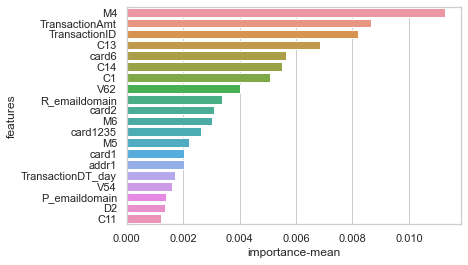

In [148]:
sns.set_theme(style="whitegrid")
sns.barplot(data=importance_scores[:20], x='importance-mean',y='features')

In [154]:
xgb = xgboost.XGBClassifier(**params_xg)
xgb.fit(
    X=x_train.drop(drop_feat, axis=1),
    y=y_train,
    eval_set=[(x_train.drop(drop_feat, axis=1), y_train), 
              (x_test.drop(drop_feat, axis=1), y_test)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.64972	validation_1-auc:0.65106
[50]	validation_0-auc:0.88156	validation_1-auc:0.88257
[100]	validation_0-auc:0.90677	validation_1-auc:0.90700
[150]	validation_0-auc:0.91572	validation_1-auc:0.91475
[199]	validation_0-auc:0.91812	validation_1-auc:0.91667


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=4, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=101, reg_alpha=0.6,
              reg_lambda=100, scale_pos_weight=1, seed=101, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# повысился

Задание 4: использовать
shap
, выполнить задание 1 и 2.

In [226]:
xgb = xgboost.XGBClassifier(**params_xg)
xgb.fit(
    X=x_train,
    y=y_train,
    eval_set=[(x_train, y_train), 
              (x_test, y_test)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.64972	validation_1-auc:0.65107
[50]	validation_0-auc:0.87816	validation_1-auc:0.87948
[100]	validation_0-auc:0.90463	validation_1-auc:0.90367
[150]	validation_0-auc:0.91505	validation_1-auc:0.91236
[199]	validation_0-auc:0.91715	validation_1-auc:0.91409


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=4, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=101, reg_alpha=0.6,
              reg_lambda=100, scale_pos_weight=1, seed=101, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test, y_test)

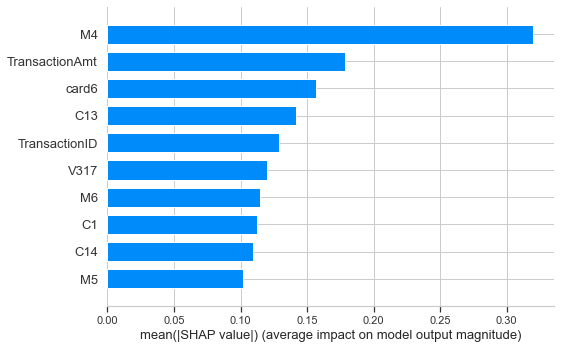

In [237]:
shap.summary_plot(shap_values, x, plot_type="bar",max_display=10 )

In [207]:
importance_scores = pd.DataFrame({
    "features": x_train.columns,
    "importance-mean": shap_values.mean(axis=0),
    "importance-std": shap_values.std(axis=0),
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"].abs()<=0.0001]
decrease_scores = decrease_scores.reset_index(drop=True)
drop_feat=decrease_scores['features'].tolist()

In [208]:
xgb = xgboost.XGBClassifier(**params_xg)
xgb.fit(
    X=x_train.drop(drop_feat, axis=1),
    y=y_train,
    eval_set=[(x_train.drop(drop_feat, axis=1), y_train), 
              (x_test.drop(drop_feat, axis=1), y_test)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=50
)

[0]	validation_0-auc:0.64728	validation_1-auc:0.64974
[50]	validation_0-auc:0.87731	validation_1-auc:0.87969
[100]	validation_0-auc:0.90565	validation_1-auc:0.90513
[150]	validation_0-auc:0.91522	validation_1-auc:0.91234
[199]	validation_0-auc:0.92003	validation_1-auc:0.91607


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.09, max_delta_step=0,
              max_depth=4, min_child_weight=4, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=8,
              num_parallel_tree=1, random_state=101, reg_alpha=0.6,
              reg_lambda=100, scale_pos_weight=1, seed=101, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [231]:
# повысился

Задание 5: построить
shap.summary_plot
и
shap.decision_plot
для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [289]:
dependence_features=importance_scores.features.head(5).tolist()

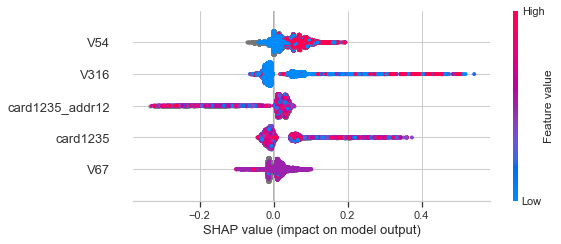

In [288]:
mask=np.isin(x_test.columns,dependence_features)
shap.summary_plot(shap_values[:, mask], x_test[dependence_features])

v54 - плотный центр масс, прямая корреляция значия признака и shap_value

v316 - растянутый центр масс,правый хвост, прямая корреляция значия признака и shap_value

card1235_addr12 - вытянутый левый хвост, ярко выраженной корреляции 
значия признака и shap_value не наблюдается

card1235 - "оторваный" правый хвост,ярко выраженной корреляции значения признака и shap_value не наблюдается

v67 - плотный центр масс,ярко выраженной корреляции значения признака и shap_value не наблюдается

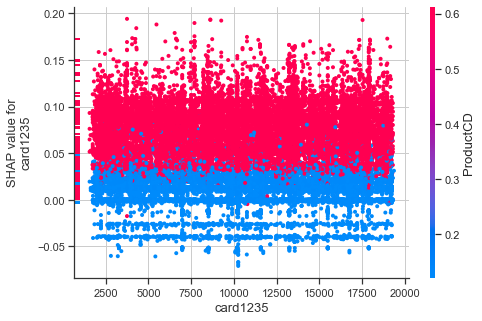

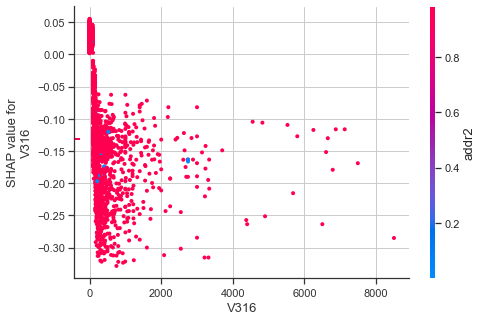

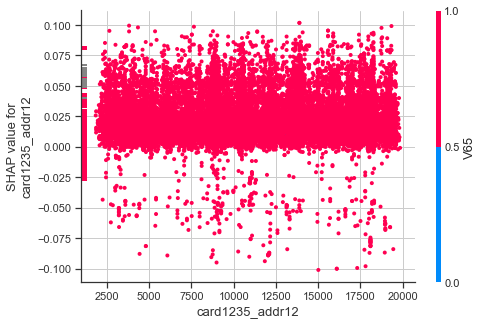

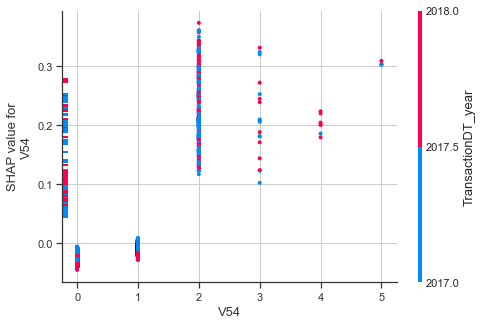

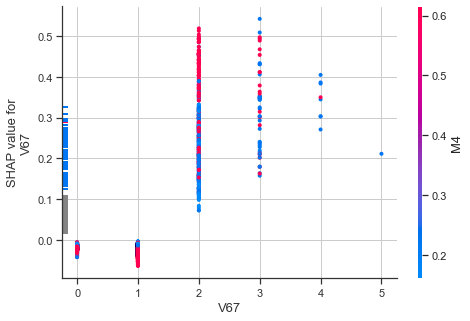

In [229]:


for name in dependence_features:
    shap.dependence_plot(name, shap_values, x_test)

card1235 - разброс значений shap value во всем диапозоне значений признака,
прямая зависимость shap value от ProductCD


v316 - все значения признака расположены в узком диапозоне,
зависимость shap value от взаимодействия с addr2 не наблюдается

card1235_addr12 -  разброс значений shap value во всем диапозоне значений признака, корреляции с V65 не наблюдается

v54 - значения признака расположены в узком диапозоне дискретных значений, выраженной корреляции
с TransactionDTyear не наблюдается.

v67 - значения признака расположены в узком диапозоне дискретных значений,
есть определенная корреляция изменений shap value с М4